# Import Libraries

In [214]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import Data from .csv

In [215]:
df_raw = pd.read_csv('../data/Prepared data/2020_features.csv')
df_raw.head()

,timestamp,load,weathertime,temp,wspd,pressure,precip_hrly,dow,doy,day,month,hour,minute,year
0,2020-01-01 00:00:00,1208.4,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,0,2020
1,2020-01-01 00:05:00,1191.0,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,5,2020
2,2020-01-01 00:10:00,1195.5,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,10,2020
3,2020-01-01 00:15:00,1210.9,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,15,2020
4,2020-01-01 00:20:00,1186.3,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,20,2020


# Add Day Type (weekday, weekend, holiday)

In [216]:
import datetime
import holidays

def is_workday(date:datetime.date):
    """
    Determines the type of day (workday or not) for a given date.

    Args:
        date (datetime.date): The date to check.

    Returns:
        int: 1 if workday else 0.
    """
    # Get the US holidays
    us_holidays = holidays.US()

    # Check if the date is a holiday
    if date in us_holidays:
        return 0

    # Check if the date is a weekend
    if date.weekday() >= 5:  # Saturday is 5, Sunday is 6
        return 0

    # Otherwise, it's a weekday
    return 1


In [217]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X['timestamp'] = pd.to_datetime(X['timestamp'])
        X['is_workday'] = X['timestamp'].apply(lambda x: is_workday(x.date()))
        X['year'] = X['timestamp'].dt.year
        X['month'] = X['timestamp'].dt.month
        X['day'] = X['timestamp'].dt.day
        X['hour'] = X['timestamp'].dt.hour
        X = X.drop('timestamp', axis=1)
        return X

In [218]:
df = df_raw[['timestamp', 'load', 'temp']].copy()
del df_raw

# Data Preprossing

In [219]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

timestamp_transformer = TimestampTransformer()
df = timestamp_transformer.transform(df)
imputer = SimpleImputer(strategy='mean')
df['load'] = imputer.fit_transform(df[['load']])
scaler_temp = StandardScaler()
scaler_load = StandardScaler()
df['temp'] = scaler_temp.fit_transform(df[['temp']])
df['load'] = scaler_load.fit_transform(df[['load']])

# Make Dataset

In [220]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len=1, transform=None, target_transform=None):
        """
        Custom Dataset for multivariate time series.

        Args:
            df (pd.Dataframe): Assume the dataframe has been preprocessed and has only numeriacal values.
            seq_length (int): Length of each sequence.
            transform: Composition of transformations.
        """
        super(TimeSeriesDataset, self).__init__()
        self.df = df
        self.features = self.df.values
        self.targets = self.df['load'].values
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.features) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.seq_len, :]
        sequence = torch.tensor(sequence, dtype=torch.float32)
        
        target = self.targets[idx + self.seq_len: idx + self.seq_len + self.pred_len]
        target = torch.tensor(target, dtype=torch.float32)
        
        return sequence, target

In [221]:
import numpy as np

dataset = TimeSeriesDataset(df, seq_len=288, pred_len=288)
train_size = int(0.8 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# Make Dataloader

In [222]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Model Implementation

In [223]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

class SimpleGRU(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

# Training

In [224]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

In [ ]:
import matplotlib.pyplot as plt

def model_evaluation(model, criterion, data_loader, device='cpu'):

    batch_losses = []

    model.eval() # switch to evalution mode
    with torch.no_grad():
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())

    model.train() # switch to training mode

    loss_mean = np.mean(batch_losses)

    return loss_mean

def training_loop(n_epochs, optimizer, model, criterion, train_loader, test_loader, verbose=False, device='cpu', save_model=None, save_as='model.pt'):
    '''
    Set `verbose=True` to see scores for each epoch. If cuda is available, set `device='cuda'`.

    Return
    ------
    - train_losses (list): history of training loss
    - test_losses (list): history of test/validation loss
    '''
    train_losses = []
    test_losses = []

    min_test_loss = float('inf')
    for n in range(n_epochs):
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        train_loss = model_evaluation(model, criterion, train_loader, device=device)
        test_loss = model_evaluation(model, criterion, test_loader, device=device)

        # save model with lowest test/validation loss
        if test_loss < min_test_loss:
            min_test_loss = test_loss
            if save_model == 'best':
                torch.save(model.state_dict(), save_as)

        # save model at last epoch
        if save_model == 'last' and n == n_epochs - 1:
            torch.save(model.state_dict(), save_as)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if ((n + 1) % 10 == 0) or verbose:
            print(f'Epoch {n + 1}/{n_epochs}: Training loss {train_loss:.4f}, Validation Loss {test_loss:.4f}')
            print('----------------------------------------------------------')

    return train_losses, test_losses

def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1/20: Training loss 0.7168, Validation Loss 0.5739
----------------------------------------------------------
Epoch 2/20: Training loss 0.9347, Validation Loss 0.4194
----------------------------------------------------------
Epoch 3/20: Training loss 1.0015, Validation Loss 0.5040
----------------------------------------------------------
Epoch 4/20: Training loss 0.7549, Validation Loss 0.7158
----------------------------------------------------------
Epoch 5/20: Training loss 0.9477, Validation Loss 0.6893
----------------------------------------------------------
Epoch 6/20: Training loss 1.5861, Validation Loss 0.8664
----------------------------------------------------------
Epoch 7/20: Training loss 1.1312, Validation Loss 0.4811
----------------------------------------------------------
Epoch 8/20: Training loss 1.2272, Validation Loss 0.5494
----------------------------------------------------------
Epoch 9/20: Training loss 1.1321, Validation Loss 0.4825
---------------

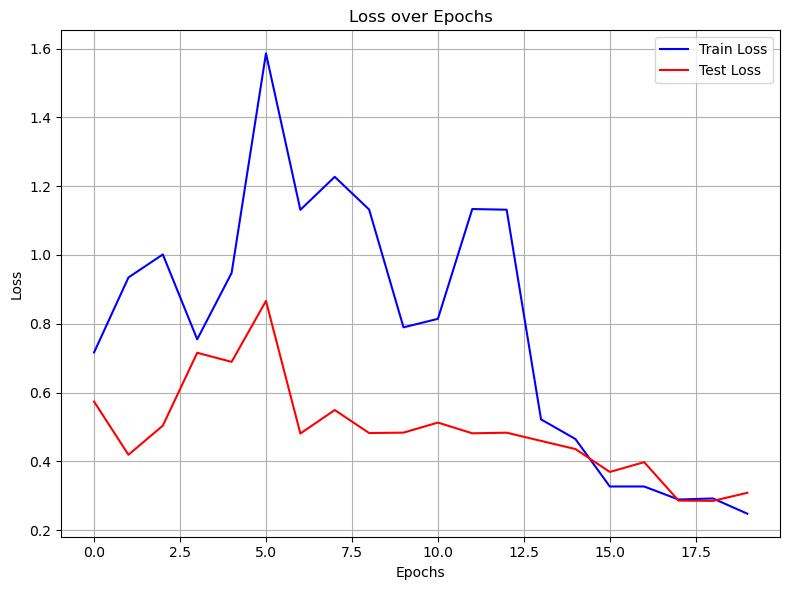

In [226]:
num_features = 7  # Number of features
output_size = 288
hidden_size = 64
num_layers = 2
num_epochs = 20
drop_rate = 0.3
lr_rate = 1e-4

lstm_model = SimpleLSTM(num_features, output_size, hidden_size, num_layers, drop_rate=drop_rate).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr_rate)

train_losses, val_losses = training_loop(
    num_epochs, 
    optimizer, 
    lstm_model, 
    criterion, 
    train_loader, 
    test_loader, 
    verbose=True, 
    device='cuda', 
    save_model='last', 
    save_as='LSTM.pt'
)
plot_metrics(train_losses, val_losses, 'Loss')

Epoch 1/20: Training loss 0.5972, Validation Loss 0.4681
----------------------------------------------------------
Epoch 2/20: Training loss 0.2923, Validation Loss 0.2010
----------------------------------------------------------
Epoch 3/20: Training loss 0.2455, Validation Loss 0.1807
----------------------------------------------------------
Epoch 4/20: Training loss 0.2162, Validation Loss 0.1595
----------------------------------------------------------
Epoch 5/20: Training loss 0.2270, Validation Loss 0.1425
----------------------------------------------------------
Epoch 6/20: Training loss 0.1826, Validation Loss 0.1428
----------------------------------------------------------
Epoch 7/20: Training loss 0.1812, Validation Loss 0.1747
----------------------------------------------------------
Epoch 8/20: Training loss 0.1729, Validation Loss 0.1372
----------------------------------------------------------
Epoch 9/20: Training loss 0.1666, Validation Loss 0.1632
---------------

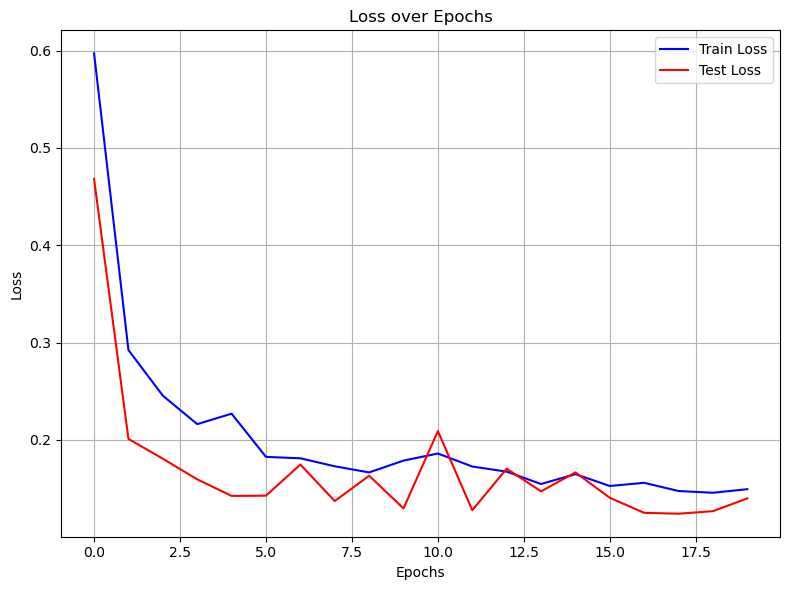

In [227]:
gru_model = SimpleGRU(num_features, output_size, hidden_size, num_layers).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr_rate)

train_losses, val_losses = training_loop(
    num_epochs, 
    optimizer, 
    gru_model, 
    criterion, 
    train_loader, 
    test_loader, 
    verbose=True, 
    device='cuda', 
    save_model='last',
    save_as='GRU.pt'
)
plot_metrics(train_losses, val_losses, 'Loss')

# Make Predictions


In [228]:
# get 2021 data
df_2021_raw = pd.read_csv('../data/Prepared data/2021_features.csv')
df_2021 = df_2021_raw[['timestamp', 'load', 'temp']].copy()
del df_2021_raw
df_2021 = timestamp_transformer.transform(df_2021)
df_2021['temp'] = scaler_temp.transform(df_2021[['temp']])
df_2021['load'] = scaler_load.transform(df_2021[['load']])

In [229]:
def make_predictions(model, initial_data, future_data, pred_len, device='cuda'):
    '''
    Make multi-step predictions using a model that outputs `pred_len` steps at once.

    Parameters
    ----------
    model: Outputs multiple steps ahead (pred_len) at once.
    initial_data (tensor): The initial historical data (sequence) to start predictions from.
    future_data (tensor): Future features for each timestep. Has columns e.g., 'load', 'temp', 'is_workday', 'month', 'day', 'hour'.
                          The first column should be the 'load' placeholder (currently unknown future load).
    pred_len (int): The number of future steps the model predicts at each call.
    device (str): Device to run computations on ('cuda' or 'cpu').

    Returns
    -------
    predictions (list): List of predicted load values (normalized).
    '''

    initial_data = initial_data.to(device)
    future_data = future_data.to(device)

    predictions = []
    sequence = initial_data

    total_future_steps = len(future_data)
    start_idx = 0

    model.eval()
    with torch.no_grad():
        while start_idx < total_future_steps:
            # Run model to predict the next pred_len steps
            # Output shape: [1, pred_len]
            pred_loads = model(sequence.unsqueeze(0)).squeeze(0)  # shape: [pred_len]
            
            steps_to_predict = min(pred_len, total_future_steps - start_idx)
            
            # Store only the needed predictions if less than pred_len steps remain
            predicted_values = pred_loads[:steps_to_predict].cpu().tolist()
            predictions.extend(predicted_values)
            
            # For each predicted step, combine the predicted load with its corresponding future features
            new_rows = []
            for i in range(steps_to_predict):
                # pred_load is a single predicted value
                pred_load = pred_loads[i].unsqueeze(0).unsqueeze(0)  # shape: [1,1]
                # The future_data row has shape [features], the first feature is 'load', which we replace
                # with the predicted load. The rest of the columns remain from future_data.
                next_data = torch.cat([pred_load, future_data[start_idx + i, 1:].unsqueeze(0)], dim=1)  # shape: [1, features]
                new_rows.append(next_data)

            # Concatenate all new rows for this batch
            new_rows = torch.cat(new_rows, dim=0)  # shape: [steps_to_predict, features]

            # Update the sequence: discard the oldest steps and add the newly predicted steps
            seq_len = sequence.size(0)
            # Remove as many old steps as we add new steps, so sequence length remains constant
            sequence = torch.cat([sequence[steps_to_predict:], new_rows], dim=0)

            start_idx += steps_to_predict

    return predictions


In [230]:
# Load saved models

lstm_model = SimpleLSTM(7, 288, 64, 2).to('cuda')
lstm_model.load_state_dict(torch.load('LSTM.pt', weights_only=True))
# lstm_model.eval()

gru_model = SimpleGRU(7, 288, 64, 2).to('cuda')
gru_model.load_state_dict(torch.load('GRU.pt', weights_only=True))
# gru_model.eval()

<All keys matched successfully>

## Test on training dataset

In [231]:
initial_np = df.iloc[:288].to_numpy(dtype=np.float32)
initial_tensor = torch.tensor(initial_np, dtype=torch.float32)
future_np = df.iloc[288:4*288].to_numpy(dtype=np.float32)
future_tensor = torch.tensor(future_np, dtype=torch.float32)

predictions_lstm = make_predictions(lstm_model, initial_tensor, future_tensor, pred_len=288, device='cuda')
predictions_gru = make_predictions(gru_model, initial_tensor, future_tensor, pred_len=288, device='cuda')

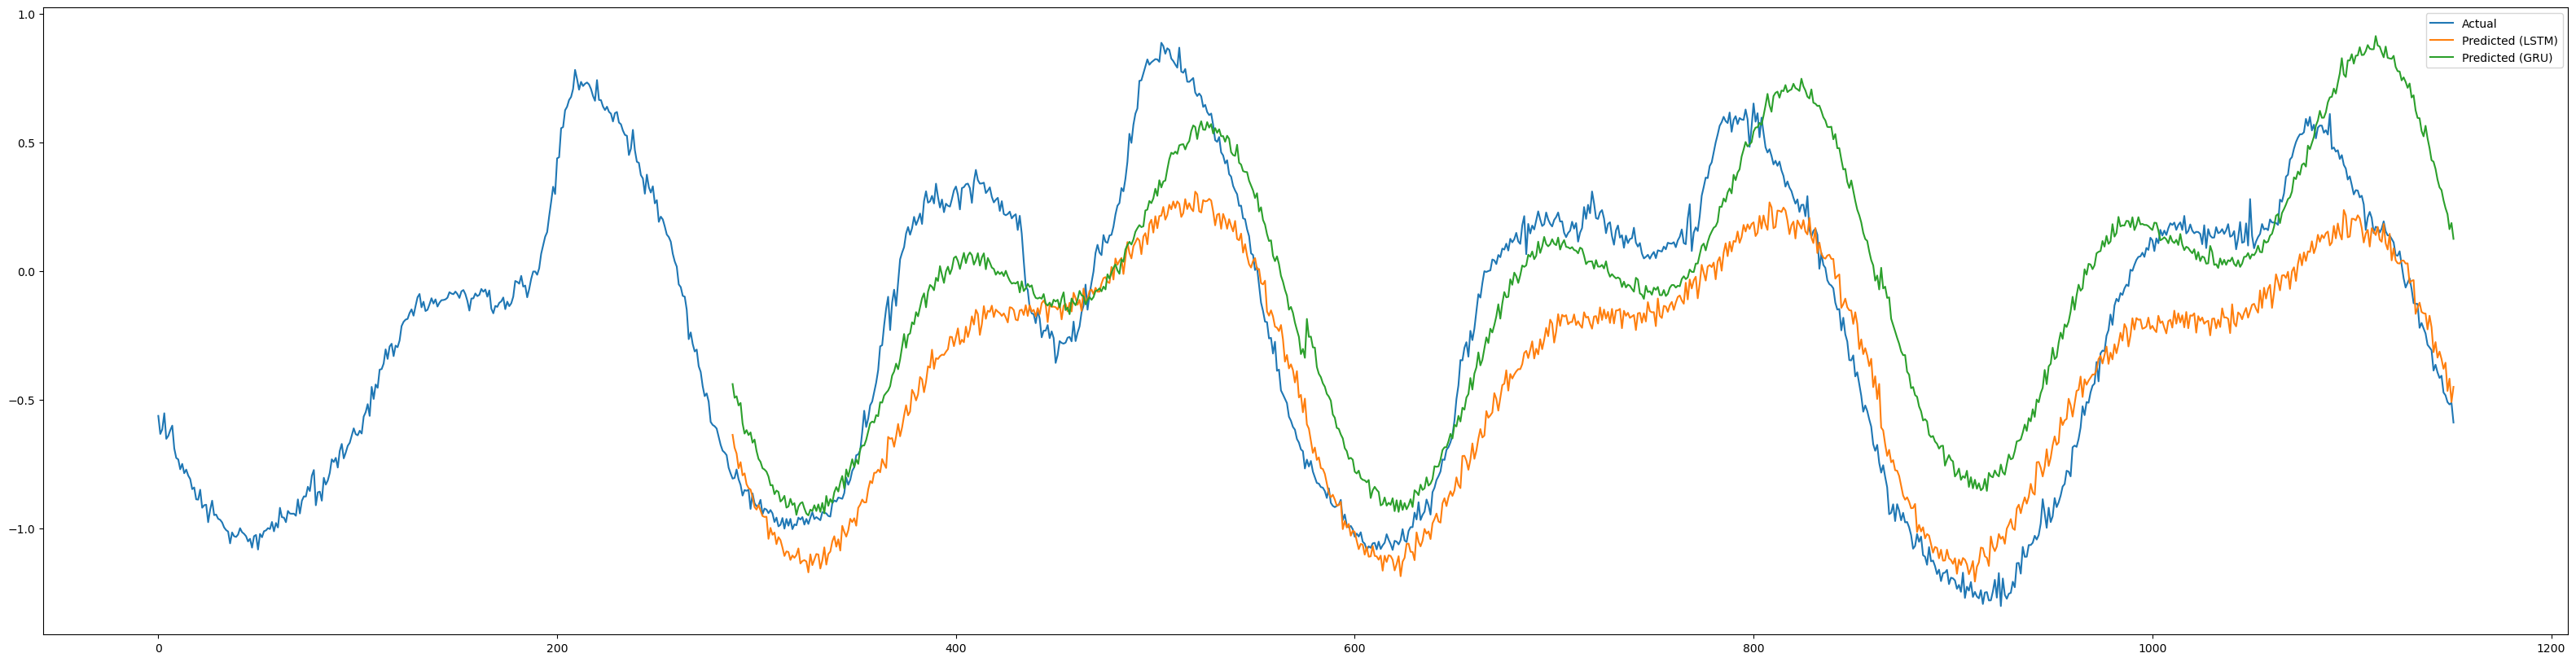

In [232]:
import matplotlib.pyplot as plt

initial = df.iloc[:288]['load'].values
future = df.iloc[288:4*288]['load'].values
actual = np.concatenate([initial, future])

plt.figure(figsize=(40, 10))
plt.plot(actual, label='Actual')
# shift the predictions to align with the actual data
plt.plot([None]*288 + predictions_lstm, label='Predicted (LSTM)')
plt.plot([None]*288 + predictions_gru, label='Predicted (GRU)')
plt.legend()
plt.show()

## Test on unseen data from 2021

In [233]:
initial_np = df.iloc[-288:].to_numpy(dtype=np.float32)
initial_tensor = torch.tensor(initial_np, dtype=torch.float32)
future_np = df_2021.iloc[:288*3].to_numpy(dtype=np.float32)
future_tensor = torch.tensor(future_np, dtype=torch.float32)

predictions_lstm = make_predictions(lstm_model, initial_tensor, future_tensor, pred_len=288, device='cuda')
predictions_gru = make_predictions(gru_model, initial_tensor, future_tensor, pred_len=288, device='cuda')

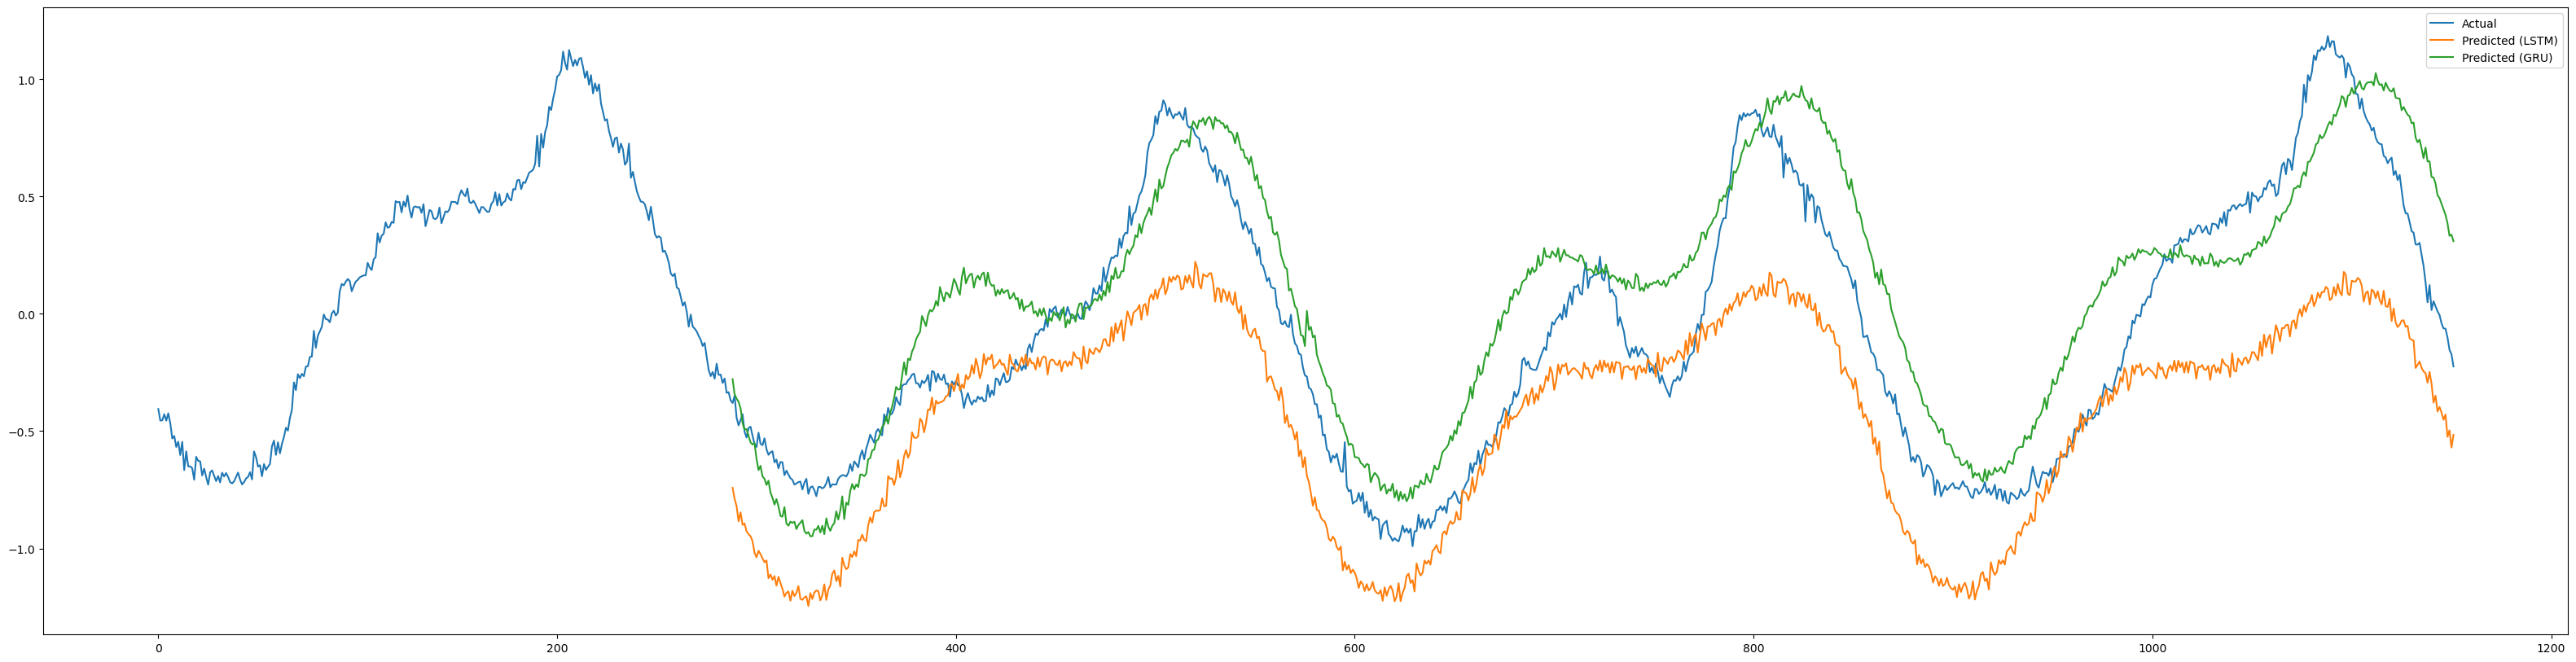

In [234]:
initial = df.iloc[-288:]['load'].values
future = df_2021.iloc[:3*288]['load'].values
actual = np.concatenate([initial, future])

plt.figure(figsize=(40, 10))
plt.plot(actual, label='Actual')
# shift the predictions to align with the actual data
plt.plot([None]*288 + predictions_lstm, label='Predicted (LSTM)')
plt.plot([None]*288 + predictions_gru, label='Predicted (GRU)')
plt.legend()
plt.show()